In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
anime_df = pd.read_csv(r"C:\Datasets\animeRec\anime.csv")
rating_df = pd.read_csv(r"C:\Datasets\animeRec\rating.csv")

In [3]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [6]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [7]:
anime_df = anime_df.dropna(subset=['type', 'genre',])

In [8]:
anime_df = anime_df[~anime_df['genre'].str.contains('henati', na=False)]

In [9]:
anime_df['rating'] = anime_df['rating'].fillna(anime_df['rating'].mean())

In [10]:
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [11]:
anime_df['genre'] = anime_df['genre'].str.lower().str.replace(',', ' |')

In [12]:
anime_df[['name', 'genre']].head()

,name,genre
0,Kimi no Na wa.,drama | romance | school | supernatural
1,Fullmetal Alchemist: Brotherhood,action | adventure | drama | fantasy | magic |...
2,Gintama°,action | comedy | historical | parody | samura...
3,Steins;Gate,sci-fi | thriller
4,Gintama&#039;,action | comedy | historical | parody | samura...


In [13]:
anime_df = anime_df.drop_duplicates(subset=['name'], keep='first')


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
anime_df['normalized_rating'] = scaler.fit_transform(anime_df[['rating']])

anime_df[['name', 'rating', 'normalized_rating']].head()

,name,rating,normalized_rating
0,Kimi no Na wa.,9.37,0.924370
1,Fullmetal Alchemist: Brotherhood,9.26,0.911164
2,Gintama°,9.25,0.909964
3,Steins;Gate,9.17,0.900360
4,Gintama&#039;,9.16,0.899160


In [15]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12208 entries, 0 to 12293
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   anime_id           12208 non-null  int64  
 1   name               12208 non-null  object 
 2   genre              12208 non-null  object 
 3   type               12208 non-null  object 
 4   episodes           12208 non-null  object 
 5   rating             12208 non-null  float64
 6   members            12208 non-null  int64  
 7   normalized_rating  12208 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 858.4+ KB


In [17]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [16]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime_df['genre'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=anime_df['name'], columns=tfidf.get_feature_names_out())

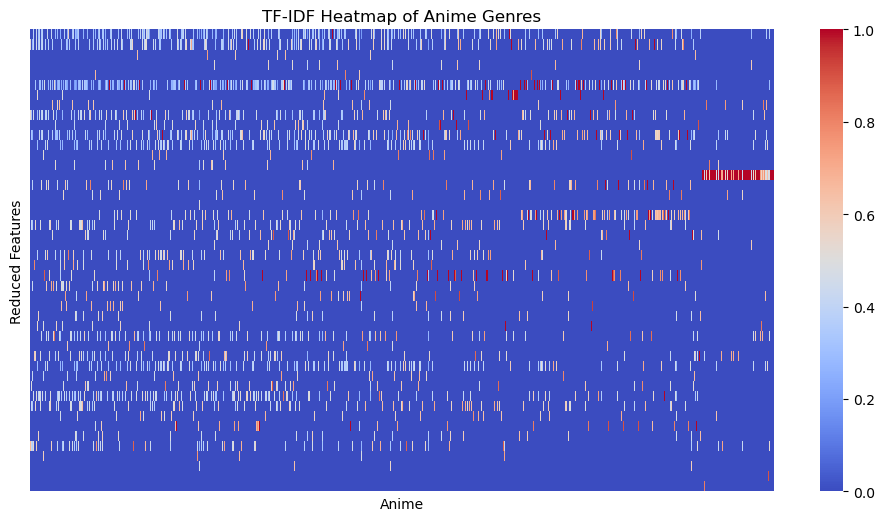

In [18]:
from wordcloud import WordCloud


In [17]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [18]:
def recommend_anime(title, df, cosine_sim):
    if title not in df['name'].values:
        return "Anime not found. Please try another title."

    idx = df[df['name'] == title].index[0] 
    sim_scores = list(enumerate(cosine_sim[idx]))  
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  
    anime_indices = [i[0] for i in sim_scores]  
    
    return df.iloc[anime_indices][['name', 'genre']]

# Example Usage
recommend_anime("Naruto", anime_df, cosine_sim)


,name,genre
615,Naruto: Shippuuden,action | comedy | martial arts | shounen | sup...
841,Naruto,action | comedy | martial arts | shounen | sup...
1103,Boruto: Naruto the Movie - Naruto ga Hokage ni...,action | comedy | martial arts | shounen | sup...
1343,Naruto x UT,action | comedy | martial arts | shounen | sup...
1472,Naruto: Shippuuden Movie 4 - The Lost Tower,action | comedy | martial arts | shounen | sup...


In [19]:
from surprise import Dataset, Reader
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_df[['user_id', 'anime_id', 'rating']], reader)


In [20]:
from surprise import SVD
from surprise.model_selection import cross_validate

In [21]:
model = SVD()

In [22]:
cross_validate(model, data, cv=2, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    2.2828  2.2821  2.2825  0.0003  
MAE (testset)     1.6056  1.6065  1.6061  0.0004  
Fit time          58.24   52.75   55.49   2.74    
Test time         29.02   24.98   27.00   2.02    


{'test_rmse': array([2.28281562, 2.28214608]),
 'test_mae': array([1.60564424, 1.60649763]),
 'fit_time': (58.23585510253906, 52.75153684616089),
 'test_time': (29.017154216766357, 24.981675148010254)}

In [23]:
from surprise.model_selection import train_test_split 

In [24]:
# Split dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [25]:

# Train model on trainset
model.fit(trainset)
predictions = model.test(testset)


In [26]:
from collections import defaultdict

def get_top_recommendations(user_id, model, anime_df, n=5):
    anime_ids = anime_df['anime_id'].unique()  # Get all anime IDs
    user_rated = rating_df[rating_df['user_id'] == user_id]['anime_id']  # Anime user has rated
    unseen_anime = set(anime_ids) - set(user_rated)  # Find unseen anime

    predictions = [model.predict(user_id, anime_id) for anime_id in unseen_anime]
    predictions.sort(key=lambda x: x.est, reverse=True)  # Sort by predicted rating

    top_anime = [anime_id for anime_id in predictions[:n]]
    
    recommended_titles = anime_df[anime_df['anime_id'].isin([p.iid for p in top_anime])]
    return recommended_titles[['anime_id', 'name', 'genre']]

get_top_recommendations(user_id=1, model=model, anime_df=anime_df, n=5)


,anime_id,name,genre
3548,32741,Girls und Panzer der Film: Fushou - Akiyama Yu...,military | school
6178,31676,Persona 2: Another Self,action | demons | fantasy | supernatural
7046,4042,Hanappe Bazooka,action | comedy | ecchi | magic | school
7596,4390,Sora no Momotarou,adventure | comedy | military
7958,6851,Kaitei no Boukun,adventure


In [27]:
def hybrid_recommend(user_id, anime_name, n=5):
    """Returns hybrid recommendations combining CF & CBF"""
    
    # Check if the user exists
    user_rated_anime = rating_df[rating_df['user_id'] == user_id]['anime_id']
    
    if not user_rated_anime.empty:
        # Use Collaborative Filtering (CF)
        anime_ids = anime_df['anime_id'].unique()
        predictions = [model.predict(user_id, anime_id) for anime_id in anime_ids if anime_id not in user_rated_anime]
        predictions.sort(key=lambda x: x.est, reverse=True)
        top_cf_anime = [anime_id for anime_id in predictions[:n]]
        
        return anime_df[anime_df['anime_id'].isin([p.iid for p in top_cf_anime])][['name', 'genre']]
    
    else:
        # Use Content-Based Filtering (CBF)
        if anime_name not in cosine_sim_df.index:
            return "Anime not found."
        
        # Get similar anime using cosine similarity
        similar_anime = cosine_sim_df[anime_name].sort_values(ascending=False).iloc[1:n+1]
        return similar_anime.index.tolist()

# Example Usage
hybrid_recommend(user_id=1, anime_name="Naruto", n=5)


,name,genre
3548,Girls und Panzer der Film: Fushou - Akiyama Yu...,military | school
6178,Persona 2: Another Self,action | demons | fantasy | supernatural
7046,Hanappe Bazooka,action | comedy | ecchi | magic | school
7596,Sora no Momotarou,adventure | comedy | military
7958,Kaitei no Boukun,adventure


IntText(value=15, description='User ID:')

Text(value='Hunter x Hunter ', description='Anime:')

Button(description='Get Recommendations', style=ButtonStyle())

HTML(value='<h3>🎯 Recommended Anime:</h3>')

,name,genre
14,Haikyuu!! Second Season,comedy | drama | school | shounen | sports
68,Shouwa Genroku Rakugo Shinjuu,drama | historical | josei
129,Kizumonogatari I: Tekketsu-hen,mystery | supernatural | vampire
242,Osomatsu-san,comedy | parody
1367,Shashinkan,drama | historical | slice of life


C:\Users\manas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


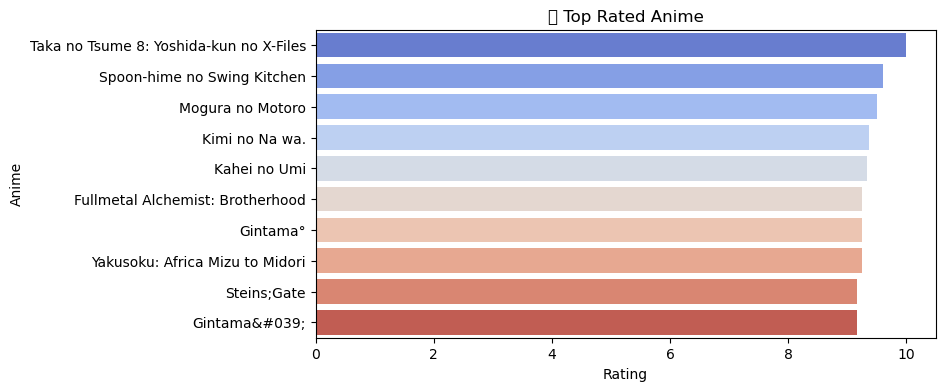

C:\Users\manas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


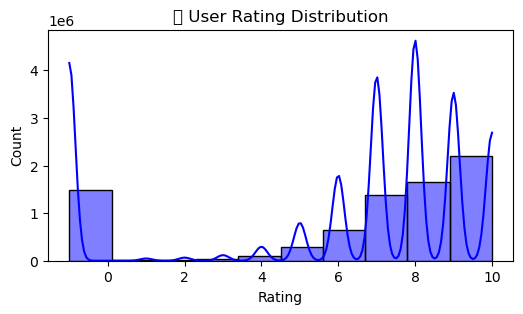

IntText(value=1, description='User ID:')

Text(value='Naruto', description='Anime:')

Button(description='Get Recommendations', style=ButtonStyle())

In [41]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

# Create interactive widgets
user_id_widget = widgets.IntText(value=1, description="User ID:")
anime_name_widget = widgets.Text(value="Naruto", description="Anime:")
button = widgets.Button(description="Get Recommendations")

# Function to update the dashboard
def update_dashboard(b):
    clear_output(wait=True)  # Clear previous outputs
    display(user_id_widget, anime_name_widget, button)  # Re-display widgets

    # Get user input
    user_id = user_id_widget.value
    anime_name = anime_name_widget.value

    # Display recommendations
    display(widgets.HTML("<h3>🎯 Recommended Anime:</h3>"))
    display(hybrid_recommend(user_id, anime_name, n=5))  

    # Top Rated Anime
    top_anime = anime_df.nlargest(10, "rating")
    plt.figure(figsize=(8, 4))
    sns.barplot(x="rating", y="name", data=top_anime, palette="coolwarm")
    plt.xlabel("Rating")
    plt.ylabel("Anime")
    plt.title("📈 Top Rated Anime")
    plt.show()

    # User Rating Distribution
    plt.figure(figsize=(6, 3))
    sns.histplot(rating_df["rating"], bins=10, kde=True, color="blue")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.title("📊 User Rating Distribution")
    plt.show()

# Attach button click event
button.on_click(update_dashboard)

# Display widgets
display(user_id_widget, anime_name_widget, button)


C:\Users\manas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


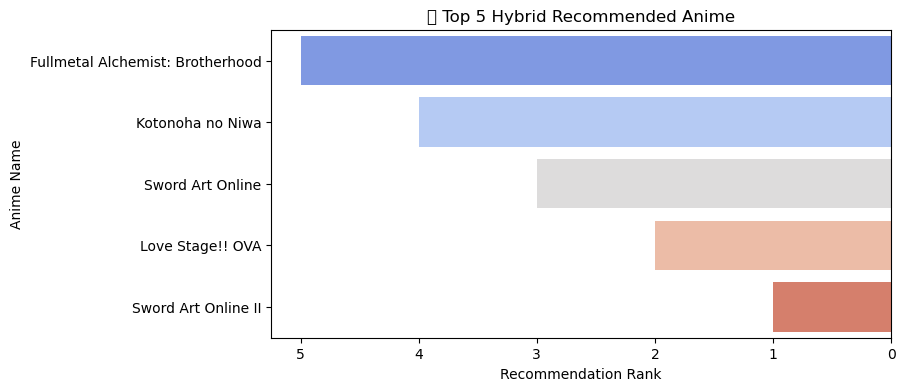

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_5_recommendations(user_id, anime_name, n=5):
    """Visualize Top 5 Hybrid Recommendations"""
    
    recommendations = hybrid_recommend(user_id, anime_name, n)
    
    # Handle different outputs from CF and CBF
    if isinstance(recommendations, list):  # CBF Output
        recommended_anime = pd.DataFrame({"Anime": recommendations, "Score": range(n, 0, -1)})
    else:  # CF Output (DataFrame with ratings)
        recommended_anime = recommendations.rename(columns={"name": "Anime"}).copy()
        recommended_anime["Score"] = range(n, 0, -1)  # Ranking scores for visualization
    
    # 📊 Create the Bar Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x="Score", y="Anime", data=recommended_anime, palette="coolwarm", orient="h")
    plt.xlabel("Recommendation Rank")
    plt.ylabel("Anime Name")
    plt.title(f"🔥 Top {n} Hybrid Recommended Anime")
    plt.gca().invert_xaxis()  # Invert to show Rank 1 at the top
    plt.show()

# Example Usage:
plot_top_5_recommendations(user_id=10, anime_name="Haikyuu!!", n=5)
